# MC REINFORCE

In [1]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print("State shape:", state_shape)
print("Number of Actions: ",no_of_actions)
print("Sampled Action",env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print("Current_State: ",state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print("Sampled Action2: ", action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next_State: ",next_state)
print("Reward: ",reward)
print("Done: ", done)
print("Info: ", info)
print("----")


State shape: 4
Number of Actions:  2
Sampled Action 0
----
Current_State:  [ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
Sampled Action2:  1
----
Next_State:  [ 0.01323574  0.17272775 -0.04686959 -0.3551522 ]
Reward:  1.0
Done:  False
Info:  {}
----


# MC REINFORCE W/O BASELINE

In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import torch
import numpy as np
from collections import deque, namedtuple

from scipy.special import softmax
from torch.distributions import Categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
'''BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)'''

class Policy(nn.Module):

    def __init__(self, state_size, action_size, seed=0, num_policy_layers =1,num_policy_layer_units= 64):
        super(Policy, self).__init__()
        self.seed = torch.manual_seed(seed)
        activation = nn.LeakyReLU
        self.fc_start = nn.Sequential(*[nn.Linear(state_size, num_policy_layer_units),activation()])
        self.fc_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_policy_layer_units,num_policy_layer_units),activation()]) for _ in range(num_policy_layers-1)])
        self.fc_end = nn.Linear(num_policy_layer_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        xs = self.fc_start(state)
        x_hidden = self.fc_hidden(xs)
        x_out = self.fc_end(x_hidden)
        return F.softmax(x_out, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)


In [4]:
class Baseline(nn.Module):
    def __init__(self, state_size, seed=0, num_baseline_layers =1,num_baseline_layer_units= 64):
        super(Baseline, self).__init__()
        self.seed = torch.manual_seed(seed)
        activation = nn.LeakyReLU
        self.fc_start = nn.Sequential(*[nn.Linear(state_size, num_baseline_layer_units),activation()])
        self.fc_hidden = nn.Sequential(*[nn.Sequential(*[nn.Linear(num_baseline_layer_units,num_baseline_layer_units),activation()]) for _ in range(num_baseline_layers-1)])
        self.fc_end = nn.Linear(num_baseline_layer_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        xs = self.fc_start(state)
        x_hidden = self.fc_hidden(xs)
        x_out = self.fc_end(x_hidden)
        return x_out

In [5]:
def reinforce_with_baseline(policy, baseline, optimizer_policy, optimizer_baseline, n_episodes=1000, max_t=1000, gamma=0.99, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(n_episodes):
        saved_log_probs = []
        rewards = []
        states = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            states.append(state)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Convert trajectory to torch tensors
        states = torch.FloatTensor(np.array(states)).to(device)
        rewards = torch.FloatTensor(rewards)

        # Calculate discounted returns
        discounts = torch.FloatTensor([gamma ** i for i in range(len(rewards))])
        returns = torch.FloatTensor([sum(rewards[i:] * discounts[:len(rewards)-i]) for i in range(len(rewards))]).to(device)

        # Calculate baseline values and advantages
        baseline_values = baseline(states).squeeze()
        advantages = returns - baseline_values

        # Calculate policy loss
        policy_loss = [-log_prob * advantage.detach().cpu() for log_prob, advantage in zip(saved_log_probs, advantages)]
        policy_loss = torch.cat(policy_loss).sum()

        # Calculate baseline loss
        baseline_loss = F.mse_loss(baseline_values, returns)

        # Backpropagation and optimization step
        optimizer_policy.zero_grad()
        policy_loss.backward()
        optimizer_policy.step()

        optimizer_baseline.zero_grad()
        baseline_loss.backward()
        optimizer_baseline.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
    return scores

In [8]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
num_exp = 5
max_episodes = 1000
total_rewards = np.zeros([num_exp,max_episodes])
for i in range(num_exp):
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    policy = Policy(state_size=state_shape, action_size=action_shape, seed=i, num_policy_layers =1,num_policy_layer_units= 128).to(device)
    baseline = Baseline(state_size=state_shape, seed=i, num_baseline_layers =1,num_baseline_layer_units= 128).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-3)
    optimizer_baseline = optim.Adam(baseline.parameters(), lr=1e-4)
    scores = reinforce_with_baseline(policy, baseline, optimizer, optimizer_baseline, n_episodes=max_episodes)
    total_rewards[i] = scores
Regret = np.mean(np.sum(500-total_rewards,axis=1),axis=0)

Episode 0	Average Score: 24.00
Episode 100	Average Score: 32.09
Episode 200	Average Score: 81.65
Episode 300	Average Score: 156.72
Episode 400	Average Score: 207.60
Episode 500	Average Score: 303.34
Episode 600	Average Score: 376.22
Episode 700	Average Score: 438.36
Episode 800	Average Score: 394.38
Episode 900	Average Score: 416.24
Episode 0	Average Score: 22.00
Episode 100	Average Score: 36.94
Episode 200	Average Score: 74.56
Episode 300	Average Score: 170.98
Episode 400	Average Score: 198.20
Episode 500	Average Score: 349.05
Episode 600	Average Score: 214.35
Episode 700	Average Score: 338.80
Episode 800	Average Score: 385.47
Episode 900	Average Score: 326.68
Episode 0	Average Score: 23.00
Episode 100	Average Score: 30.14
Episode 200	Average Score: 70.58
Episode 300	Average Score: 169.92
Episode 400	Average Score: 138.37
Episode 500	Average Score: 161.49
Episode 600	Average Score: 344.58
Episode 700	Average Score: 345.76
Episode 800	Average Score: 320.99
Episode 900	Average Score: 29

In [9]:
import pandas as pd

In [10]:
Regret_type2 = np.mean(np.sum(500-total_rewards,axis=1),axis=0)
print("\nRegret =", Regret_type2)
rewards_mean_type2 = np.mean(total_rewards,axis=0)
reward_std_type2 = np.std(total_rewards, axis=0)



Regret = 220234.6


In [11]:
data = np.vstack([rewards_mean_type2,reward_std_type2]).T
dff= pd.DataFrame(np.array(data),columns = ["Mean","Std"])
dff.to_csv("MC_REINFORCE_WB_3AM.csv", index = False)

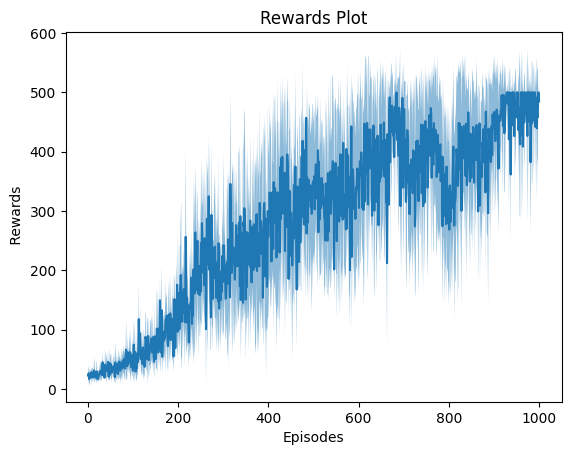

In [12]:
plt.plot(np.arange(1,len(rewards_mean_type2)+1),rewards_mean_type2)
plt.fill_between(np.arange(1,len(rewards_mean_type2)+1),rewards_mean_type2 - reward_std_type2,rewards_mean_type2 + reward_std_type2, alpha=0.5)
plt.xlabel("Episodes")
plt.ylabel(" Rewards")
plt.title("Rewards Plot")
plt.show()

# Final Draft

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login(key = "8545e71f98dc96fbac53295facb12404fc77016d")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nayin\.netrc


True

In [ ]:
def train_and_tune(config=None):
  # Initialize a new wandb run
  with wandb.init(config=config):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config
    wandb.run.name='plr'+str(config.policy_lr)+'blr'+str(config.baseline_lr)+'-nlr'+str(config.num_policy_layers)+'-uts'+str(config.num_policy_layer_units)+'-nlr'+str(config.num_baseline_layers)+'-uts'+str(config.num_baseline_layer_units)
    state_shape = env.observation_space.shape[0]
    action_shape = env.action_space.n
    num_exp = 1
    max_episodes = 1000
    total_rewards = np.zeros([num_exp,max_episodes])
    for i in range(num_exp):
        state_shape = env.observation_space.shape[0]
        action_shape = env.action_space.n

        policy = Policy(state_size=state_shape, action_size=action_shape, seed=i, num_policy_layers =config.num_policy_layers,num_policy_layer_units= config.num_policy_layer_units).to(device)
        baseline = Baseline(state_size=state_shape, seed=i, num_baseline_layers =config.num_baseline_layers,num_baseline_layer_units= config.num_baseline_layer_units).to(device)
        optimizer_policy = optim.Adam(policy.parameters(), lr=config.policy_lr)
        optimizer_baseline = optim.Adam(baseline.parameters(), lr=config.baseline_lr)
        scores = reinforce_with_baseline(policy, baseline, optimizer_policy, optimizer_baseline, n_episodes=max_episodes)
        total_rewards[i] = scores
    Regret = np.mean(np.sum(0-total_rewards,axis=1),axis=0)
    #wandb.log({"train_mean_reward":rewards,"train_mean_steps":steps,"test_mean_reward":r,"train_mean_steps":s})
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), rewards)]
    #table1 = wandb.Table(data=data, columns=["x", "y"])
    #data = [[x, y] for (x, y) in zip(np.arange(config.episodes), steps)]
    #table2 = wandb.Table(data=data, columns=["x", "y"])
    wandb.log(
        {
            "avg_regret":Regret#,'avg_test_steps':s #,"train_reward": wandb.plot.line(table1, "x", "y", title="Reward vs Episode"),"train_steps": wandb.plot.line(table2, "x", "y", title="Steps vs Episode"),
        }
    )

In [ ]:
sweep_config={'method':'bayes',
              'metric' : {
                  'name':'avg_regret',
                  'goal':'minimize'},
              'parameters':{
                  'policy_lr':{'values':[1e-2, 1e-3, 1e-4]},
                  'baseline_lr':{'values':[1e-2, 1e-3, 1e-4]},
                  'num_policy_layers':{'values':[1,2,3]},
                  'num_policy_layer_units':{'values':[64,128,256]},
                  'num_baseline_layers':{'values':[1,2,3]},
                  'num_baseline_layer_units':{'values':[64,128,256]},
                  }}
import pprint
pprint.pprint(sweep_config)
sweep_id=wandb.sweep(sweep_config,project="CS6700_PROGRAMMING_ASSIGNMENT_2")

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'avg_regret'},
 'parameters': {'baseline_lr': {'values': [0.01, 0.001, 0.0001]},
                'num_baseline_layer_units': {'values': [64, 128, 256]},
                'num_baseline_layers': {'values': [1, 2, 3]},
                'num_policy_layer_units': {'values': [64, 128, 256]},
                'num_policy_layers': {'values': [1, 2, 3]},
                'policy_lr': {'values': [0.01, 0.001, 0.0001]}}}
Create sweep with ID: 598n0p3a
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_2/sweeps/598n0p3a


{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'avg_regret'},
 'parameters': {'baseline_lr': {'values': [0.01, 0.001, 0.0001]},
                'num_baseline_layer_units': {'values': [64, 128, 256]},
                'num_baseline_layers': {'values': [1, 2, 3]},
                'num_policy_layer_units': {'values': [64, 128, 256]},
                'num_policy_layers': {'values': [1, 2, 3]},
                'policy_lr': {'values': [0.01, 0.001, 0.0001]}}}
Create sweep with ID: shtmetho
Sweep URL: https://wandb.ai/nayinisriharsh-iitm/CS6700_PROGRAMMING_ASSIGNMENT_2/sweeps/598n0p3a

In [ ]:
wandb.agent(sweep_id, train_and_tune,count=40)

wandb: Agent Starting Run: xth279tv with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 64
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.01


Episode 0	Average Score: 63.00
Episode 100	Average Score: 15.66
Episode 200	Average Score: 9.46
Episode 300	Average Score: 9.28
Episode 400	Average Score: 9.45
Episode 500	Average Score: 9.38
Episode 600	Average Score: 9.38
Episode 700	Average Score: 9.40
Episode 800	Average Score: 9.37
Episode 900	Average Score: 9.34


avg_regret,▁
avg_regret,-10062.0


wandb: Agent Starting Run: 0ek1ebks with config:
wandb: 	baseline_lr: 0.001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.01
wandb: Currently logged in as: nayinisriharsh-iitm. Use `wandb login --relogin` to force relogin


Episode 0	Average Score: 16.00
Episode 100	Average Score: 65.32
Episode 200	Average Score: 31.42
Episode 300	Average Score: 9.07
Episode 400	Average Score: 9.38
Episode 500	Average Score: 9.30
Episode 600	Average Score: 9.50
Episode 700	Average Score: 9.38
Episode 800	Average Score: 9.40
Episode 900	Average Score: 9.35


avg_regret,▁
avg_regret,-17151.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: idv9xrz1 with config:
wandb: 	baseline_lr: 0.01
wandb: 	num_baseline_layer_units: 64
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.01


Episode 0	Average Score: 16.00
Episode 100	Average Score: 91.07
Episode 200	Average Score: 96.14
Episode 300	Average Score: 12.45
Episode 400	Average Score: 17.41
Episode 500	Average Score: 21.80
Episode 600	Average Score: 22.07
Episode 700	Average Score: 24.27
Episode 800	Average Score: 53.21
Episode 900	Average Score: 83.01


avg_regret,▁
avg_regret,-51279.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iaod3sgb with config:
wandb: 	baseline_lr: 0.001
wandb: 	num_baseline_layer_units: 64
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 16.00
Episode 100	Average Score: 26.97
Episode 200	Average Score: 37.97
Episode 300	Average Score: 80.63
Episode 400	Average Score: 148.32
Episode 500	Average Score: 205.75
Episode 600	Average Score: 196.25
Episode 700	Average Score: 206.93
Episode 800	Average Score: 226.12
Episode 900	Average Score: 223.78


avg_regret,▁
avg_regret,-150122.0


wandb: Agent Starting Run: riqgeut0 with config:
wandb: 	baseline_lr: 0.001
wandb: 	num_baseline_layer_units: 64
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 31.00
Episode 100	Average Score: 65.37
Episode 200	Average Score: 40.49
Episode 300	Average Score: 20.67
Episode 400	Average Score: 113.24
Episode 500	Average Score: 85.25
Episode 600	Average Score: 172.52
Episode 700	Average Score: 186.63
Episode 800	Average Score: 68.09
Episode 900	Average Score: 10.32


avg_regret,▁
avg_regret,-77211.0


wandb: Agent Starting Run: 1owgs5q9 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 3
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.01


Episode 0	Average Score: 25.00
Episode 100	Average Score: 51.36
Episode 200	Average Score: 26.08
Episode 300	Average Score: 67.55
Episode 400	Average Score: 59.73
Episode 500	Average Score: 66.54
Episode 600	Average Score: 195.29
Episode 700	Average Score: 33.80
Episode 800	Average Score: 9.26
Episode 900	Average Score: 9.19


avg_regret,▁
avg_regret,-52837.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xyx0t4ba with config:
wandb: 	baseline_lr: 0.001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 28.00
Episode 100	Average Score: 23.10
Episode 200	Average Score: 28.23
Episode 300	Average Score: 32.29
Episode 400	Average Score: 38.13
Episode 500	Average Score: 44.69
Episode 600	Average Score: 57.63
Episode 700	Average Score: 64.32
Episode 800	Average Score: 71.50
Episode 900	Average Score: 71.32


avg_regret,▁
avg_regret,-49389.0


wandb: Agent Starting Run: o9ai8rbi with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 64
wandb: 	num_baseline_layers: 3
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 3
wandb: 	policy_lr: 0.01


Episode 0	Average Score: 64.00
Episode 100	Average Score: 11.86
Episode 200	Average Score: 16.73
Episode 300	Average Score: 9.41
Episode 400	Average Score: 9.42
Episode 500	Average Score: 9.26
Episode 600	Average Score: 9.28
Episode 700	Average Score: 9.36
Episode 800	Average Score: 9.30
Episode 900	Average Score: 9.30


avg_regret,▁
avg_regret,-10393.0


wandb: Agent Starting Run: cu38kp10 with config:
wandb: 	baseline_lr: 0.01
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 18.00
Episode 100	Average Score: 22.07
Episode 200	Average Score: 20.99
Episode 300	Average Score: 20.97
Episode 400	Average Score: 23.38
Episode 500	Average Score: 22.47
Episode 600	Average Score: 22.17
Episode 700	Average Score: 21.51
Episode 800	Average Score: 22.92
Episode 900	Average Score: 24.77


avg_regret,▁
avg_regret,-22286.0


wandb: Agent Starting Run: e1hw5jcx with config:
wandb: 	baseline_lr: 0.01
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 3
wandb: 	num_policy_layer_units: 64
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 21.00
Episode 100	Average Score: 22.60
Episode 200	Average Score: 20.36
Episode 300	Average Score: 23.72
Episode 400	Average Score: 22.98
Episode 500	Average Score: 23.08
Episode 600	Average Score: 25.75
Episode 700	Average Score: 25.79
Episode 800	Average Score: 28.25
Episode 900	Average Score: 35.64


avg_regret,▁
avg_regret,-26219.0


wandb: Agent Starting Run: q35kz9jr with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 22.00
Episode 100	Average Score: 27.37
Episode 200	Average Score: 37.37
Episode 300	Average Score: 67.40
Episode 400	Average Score: 115.02
Episode 500	Average Score: 196.50
Episode 600	Average Score: 217.88
Episode 700	Average Score: 217.77
Episode 800	Average Score: 281.27
Episode 900	Average Score: 297.68


avg_regret,▁
avg_regret,-179544.0


wandb: Agent Starting Run: ksv7pryh with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 13.00
Episode 100	Average Score: 32.18
Episode 200	Average Score: 87.31
Episode 300	Average Score: 186.11
Episode 400	Average Score: 228.18
Episode 500	Average Score: 278.31
Episode 600	Average Score: 335.86
Episode 700	Average Score: 160.49
Episode 800	Average Score: 172.99
Episode 900	Average Score: 184.08


avg_regret,▁
avg_regret,-182917.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0w608ux7 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 14.00
Episode 100	Average Score: 26.50
Episode 200	Average Score: 46.08
Episode 300	Average Score: 65.82
Episode 400	Average Score: 129.30
Episode 500	Average Score: 180.43
Episode 600	Average Score: 171.83
Episode 700	Average Score: 199.32
Episode 800	Average Score: 155.52
Episode 900	Average Score: 142.05


avg_regret,▁
avg_regret,-125113.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1u1k08ck with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 19.00
Episode 100	Average Score: 90.26
Episode 200	Average Score: 154.17
Episode 300	Average Score: 318.78
Episode 400	Average Score: 170.20
Episode 500	Average Score: 126.22
Episode 600	Average Score: 146.06
Episode 700	Average Score: 117.67
Episode 800	Average Score: 149.28
Episode 900	Average Score: 105.00


avg_regret,▁
avg_regret,-150754.0


wandb: Agent Starting Run: k2d3p673 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 13.00
Episode 100	Average Score: 20.06
Episode 200	Average Score: 22.18
Episode 300	Average Score: 23.45
Episode 400	Average Score: 28.34
Episode 500	Average Score: 33.43
Episode 600	Average Score: 37.26
Episode 700	Average Score: 42.02
Episode 800	Average Score: 45.31
Episode 900	Average Score: 50.13


avg_regret,▁
avg_regret,-35770.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t623c63o with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 12.00
Episode 100	Average Score: 38.53
Episode 200	Average Score: 86.06
Episode 300	Average Score: 211.72
Episode 400	Average Score: 260.59
Episode 500	Average Score: 214.04
Episode 600	Average Score: 242.51
Episode 700	Average Score: 180.85
Episode 800	Average Score: 133.74
Episode 900	Average Score: 147.59


avg_regret,▁
avg_regret,-165947.0


wandb: Agent Starting Run: 0n4kefza with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 17.00
Episode 100	Average Score: 25.15
Episode 200	Average Score: 51.46
Episode 300	Average Score: 90.05
Episode 400	Average Score: 144.07
Episode 500	Average Score: 141.27
Episode 600	Average Score: 138.87
Episode 700	Average Score: 165.39
Episode 800	Average Score: 191.53
Episode 900	Average Score: 176.46


avg_regret,▁
avg_regret,-131194.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k36n2kqh with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 23.00
Episode 100	Average Score: 29.53
Episode 200	Average Score: 40.46
Episode 300	Average Score: 68.37
Episode 400	Average Score: 117.59
Episode 500	Average Score: 139.20
Episode 600	Average Score: 199.70
Episode 700	Average Score: 254.43
Episode 800	Average Score: 243.11
Episode 900	Average Score: 313.04


avg_regret,▁
avg_regret,-176322.0


wandb: Agent Starting Run: whjnocpw with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 3
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 79.00
Episode 100	Average Score: 48.16
Episode 200	Average Score: 55.85
Episode 300	Average Score: 94.46
Episode 400	Average Score: 109.96
Episode 500	Average Score: 131.02
Episode 600	Average Score: 118.92
Episode 700	Average Score: 138.92
Episode 800	Average Score: 167.83
Episode 900	Average Score: 86.77


avg_regret,▁
avg_regret,-117007.0


wandb: Agent Starting Run: 8ycpx0yd with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 3
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 18.00
Episode 100	Average Score: 38.46
Episode 200	Average Score: 68.52
Episode 300	Average Score: 153.19
Episode 400	Average Score: 132.27
Episode 500	Average Score: 152.81
Episode 600	Average Score: 173.90
Episode 700	Average Score: 148.32
Episode 800	Average Score: 154.72
Episode 900	Average Score: 181.18


avg_regret,▁
avg_regret,-143492.0


wandb: Agent Starting Run: mrkch18k with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 12.00
Episode 100	Average Score: 45.41
Episode 200	Average Score: 112.33
Episode 300	Average Score: 224.56
Episode 400	Average Score: 322.05
Episode 500	Average Score: 346.89
Episode 600	Average Score: 374.25
Episode 700	Average Score: 174.41
Episode 800	Average Score: 146.77
Episode 900	Average Score: 144.71


avg_regret,▁
avg_regret,-202862.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hp1pdf7u with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 9.00
Episode 100	Average Score: 28.67
Episode 200	Average Score: 67.16
Episode 300	Average Score: 162.44
Episode 400	Average Score: 184.18
Episode 500	Average Score: 145.08
Episode 600	Average Score: 126.14
Episode 700	Average Score: 142.02
Episode 800	Average Score: 146.17
Episode 900	Average Score: 103.28


avg_regret,▁
avg_regret,-124346.0


wandb: Agent Starting Run: tkpk03xb with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 3
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 21.00
Episode 100	Average Score: 21.19
Episode 200	Average Score: 26.78
Episode 300	Average Score: 36.48
Episode 400	Average Score: 38.05
Episode 500	Average Score: 43.72
Episode 600	Average Score: 47.38
Episode 700	Average Score: 55.83
Episode 800	Average Score: 58.44
Episode 900	Average Score: 81.13


avg_regret,▁
avg_regret,-51175.0


wandb: Agent Starting Run: r627iph4 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 9.00
Episode 100	Average Score: 37.79
Episode 200	Average Score: 60.34
Episode 300	Average Score: 146.01
Episode 400	Average Score: 248.26
Episode 500	Average Score: 139.40
Episode 600	Average Score: 121.90
Episode 700	Average Score: 198.77
Episode 800	Average Score: 152.50
Episode 900	Average Score: 169.03


avg_regret,▁
avg_regret,-145526.0


wandb: Agent Starting Run: 5ovihre3 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 10.00
Episode 100	Average Score: 30.39
Episode 200	Average Score: 85.41
Episode 300	Average Score: 150.43
Episode 400	Average Score: 196.19
Episode 500	Average Score: 123.94
Episode 600	Average Score: 137.18
Episode 700	Average Score: 131.32
Episode 800	Average Score: 112.20
Episode 900	Average Score: 111.37


avg_regret,▁
avg_regret,-118910.0


wandb: Agent Starting Run: xxmvbpzt with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 14.00
Episode 100	Average Score: 35.35
Episode 200	Average Score: 89.68
Episode 300	Average Score: 163.29
Episode 400	Average Score: 225.79
Episode 500	Average Score: 402.12
Episode 600	Average Score: 384.49
Episode 700	Average Score: 205.99
Episode 800	Average Score: 306.51
Episode 900	Average Score: 179.87


avg_regret,▁
avg_regret,-214328.0


wandb: Agent Starting Run: euj43tq8 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 25.00
Episode 100	Average Score: 33.69
Episode 200	Average Score: 75.42
Episode 300	Average Score: 175.17
Episode 400	Average Score: 195.16
Episode 500	Average Score: 285.73
Episode 600	Average Score: 233.95
Episode 700	Average Score: 422.37
Episode 800	Average Score: 475.94
Episode 900	Average Score: 476.30


avg_regret,▁
avg_regret,-286174.0


wandb: Agent Starting Run: i7aotif7 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 29.00
Episode 100	Average Score: 26.06
Episode 200	Average Score: 30.31
Episode 300	Average Score: 39.22
Episode 400	Average Score: 57.36
Episode 500	Average Score: 123.71
Episode 600	Average Score: 170.71
Episode 700	Average Score: 202.88
Episode 800	Average Score: 260.10
Episode 900	Average Score: 280.67


avg_regret,▁
avg_regret,-146477.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cji0htjb with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.0001


Episode 0	Average Score: 28.00
Episode 100	Average Score: 20.82
Episode 200	Average Score: 22.98
Episode 300	Average Score: 28.40
Episode 400	Average Score: 36.27
Episode 500	Average Score: 38.89
Episode 600	Average Score: 37.93
Episode 700	Average Score: 47.46
Episode 800	Average Score: 49.25
Episode 900	Average Score: 57.31


avg_regret,▁
avg_regret,-40420.0


wandb: Agent Starting Run: kmjr6jom with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 26.00
Episode 100	Average Score: 30.71
Episode 200	Average Score: 82.17
Episode 300	Average Score: 180.45
Episode 400	Average Score: 254.31
Episode 500	Average Score: 337.40
Episode 600	Average Score: 457.84
Episode 700	Average Score: 404.73
Episode 800	Average Score: 437.54
Episode 900	Average Score: 456.54


avg_regret,▁
avg_regret,-304151.0


wandb: Agent Starting Run: xm4l59at with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 10.00
Episode 100	Average Score: 47.22
Episode 200	Average Score: 86.12
Episode 300	Average Score: 274.42
Episode 400	Average Score: 210.42
Episode 500	Average Score: 122.42
Episode 600	Average Score: 119.01
Episode 700	Average Score: 117.08
Episode 800	Average Score: 143.66
Episode 900	Average Score: 133.31


avg_regret,▁
avg_regret,-135668.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ztatjfs5 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 2
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 16.00
Episode 100	Average Score: 36.58
Episode 200	Average Score: 96.10
Episode 300	Average Score: 167.08
Episode 400	Average Score: 270.10
Episode 500	Average Score: 340.23
Episode 600	Average Score: 362.09
Episode 700	Average Score: 299.35
Episode 800	Average Score: 228.31
Episode 900	Average Score: 174.53


avg_regret,▁
avg_regret,-211301.0


wandb: Agent Starting Run: 1x5xqqj4 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 256
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 10.00
Episode 100	Average Score: 33.45
Episode 200	Average Score: 72.32
Episode 300	Average Score: 174.64
Episode 400	Average Score: 144.83
Episode 500	Average Score: 295.90
Episode 600	Average Score: 245.15
Episode 700	Average Score: 297.91
Episode 800	Average Score: 387.54
Episode 900	Average Score: 430.98


avg_regret,▁
avg_regret,-235132.0


wandb: Agent Starting Run: p3x5yvvm with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 2
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 28.00
Episode 100	Average Score: 61.73
Episode 200	Average Score: 188.42
Episode 300	Average Score: 114.94
Episode 400	Average Score: 137.94
Episode 500	Average Score: 134.91
Episode 600	Average Score: 85.71
Episode 700	Average Score: 273.53
Episode 800	Average Score: 451.62
Episode 900	Average Score: 320.48


avg_regret,▁
avg_regret,-195272.0


wandb: Agent Starting Run: zzt3399s with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 26.00
Episode 100	Average Score: 26.45
Episode 200	Average Score: 81.36
Episode 300	Average Score: 171.91
Episode 400	Average Score: 254.43
Episode 500	Average Score: 315.10
Episode 600	Average Score: 403.25
Episode 700	Average Score: 418.55
Episode 800	Average Score: 469.59
Episode 900	Average Score: 478.85


avg_regret,▁
avg_regret,-310229.0


wandb: Agent Starting Run: 6he8jdn0 with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 256
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 10.00
Episode 100	Average Score: 30.68
Episode 200	Average Score: 69.98
Episode 300	Average Score: 157.98
Episode 400	Average Score: 220.08
Episode 500	Average Score: 280.77
Episode 600	Average Score: 439.00
Episode 700	Average Score: 440.09
Episode 800	Average Score: 456.95
Episode 900	Average Score: 404.72


avg_regret,▁
avg_regret,-274313.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pvw9wmhb with config:
wandb: 	baseline_lr: 0.0001
wandb: 	num_baseline_layer_units: 128
wandb: 	num_baseline_layers: 1
wandb: 	num_policy_layer_units: 128
wandb: 	num_policy_layers: 1
wandb: 	policy_lr: 0.001


Episode 0	Average Score: 27.00
Episode 100	Average Score: 31.35
Episode 200	Average Score: 72.30
Episode 300	Average Score: 174.92
Episode 400	Average Score: 235.42
Episode 500	Average Score: 279.35
